forked from main iowa_redistricting on march 28

manually implementing algorithm described in Chen and Rodden (2013)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 


import math         ##for math.sqrt
import random       #for random selection of district to start with

import pdb          # debugging


# Prepping the census and geopandas dataframes

## Importing data

In [2]:
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [3]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [4]:
## Merging ONLY 2020 population #s and county_id from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population','county_id']], on='COUNTYFP10').copy()

#(otherwise this merge is only done for the map point later)

In [5]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4
# top_fifth_percentile=int(np.percentile(census_df['population'],95))       # not needed here/yet, maybe later

## Projecting shapefile to UTM 15N

In [6]:
#First, show the current coordinate reference system
shapefile_iowa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

shapef_ia_proj.crs
# new_districts_shapefile_projected.crs

<Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 96°W to 90°W and NAD83 by country
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
shapef_ia_proj[['geometry']]

,geometry
0,"POLYGON ((386139.673 4557123.147, 385899.972 4..."
1,"POLYGON ((347722.464 4557927.937, 347913.212 4..."
2,"POLYGON ((621990.182 4817526.586, 622024.806 4..."
3,"POLYGON ((491767.058 4517888.762, 491767.214 4..."
4,"POLYGON ((325801.578 4617291.999, 325803.323 4..."
...,...
94,"POLYGON ((421445.925 4808992.344, 421447.824 4..."
95,"POLYGON ((574463.517 4808850.424, 574456.858 4..."
96,"POLYGON ((219197.456 4698279.860, 219185.953 4..."
97,"POLYGON ((469254.825 4789243.586, 469110.920 4..."


In [9]:
#checking out geopandas automatic distance calculation
shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid

0.0

## Merging pd and gpd dataframes and creating population heat map

In [10]:
shapefile_iowa.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry', 'population', 'county_id'],
      dtype='object')

In [11]:
# census_df.sort_values('population', ascending=False).head()
census_df.columns

Index(['county_id', 'county', 'population', 'COUNTYFP10', 'latitude',
       'longitude'],
      dtype='object')

In [12]:
# old version
# map_population_by_county_data = shapefile_iowa.merge(census_df, on='COUNTYFP10')


## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population and county_id are already there)
map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude']], on='COUNTYFP10').copy()

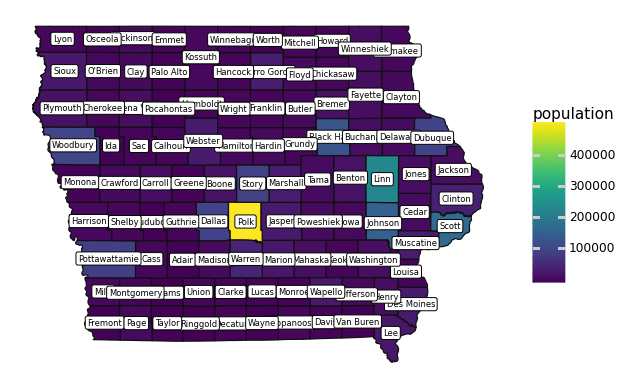

<ggplot: (8744341793612)>

In [13]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

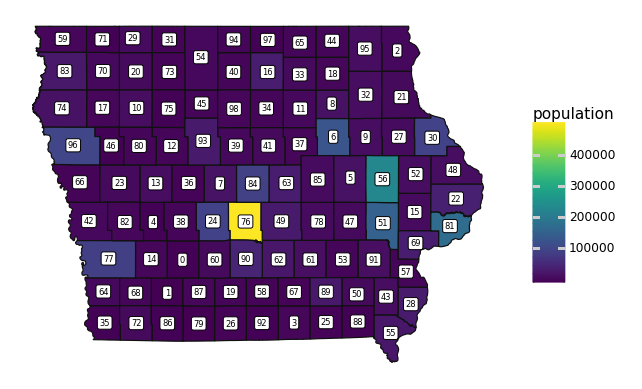

<ggplot: (8744339668411)>

In [14]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id

## Preparing geodataframe for running algorithm

In [15]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y
#shapef_ia_proj.info()
# shapef_ia_proj['xcentr_lon'].iloc[1]

In [16]:
shapef_ia_proj.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry', 'population', 'county_id', 'xcentr_lon',
       'ycentr_lat'],
      dtype='object')

In [17]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data
#      and (later on): also removing ALAND and AWATER, since they just get messy with merges and dissolves

districting_columns = ['COUNTYFP10', 'NAME10', 'geometry', 
       'population', 'county_id', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_fordistricting = shapef_ia_proj[districting_columns].copy()

#add column of county indices (which will get concatenated, as county_id_string)
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id']
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id_string'].astype(str).str.pad(2,fillchar='0')

#add column of county indices (which will become district indices)
shapef_ia_fordistricting['temp_district'] = shapef_ia_fordistricting.index

shapef_ia_fordistricting.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   temp_district     99 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 7.7+ KB


# Nearest-Neighbor district-building model

* To start, we have 99 districts, 1 for each county.
* Randomly select a district (single county at the moment!) to start with.
* Join it to its nearest neighbor (using centroid measurement of distance).
    * Make new shapefile with those two counties dissolved together (and calc new centroids/distances)
    * Now we have 98 districts. Repeat until 4 left.

This procedure preserves compactness well, but has no population controls.
After we're down to 4 districts, we will then swap counties between districts until populations stabilize.


## Building-block functions (adjacency matrix + distance matrix)

In [18]:
# function for arbitrary adjacency matrix

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersects(temp_shapefile.iloc[[i]].unary_union)
    
    adjac_mat = adjac_mat - np.identity(curr_n_districts)
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


In [19]:
#function: input is a shapefile with centroid columns, output is a distance matrix
def temp_distance_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    distance_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(i):      #just do half the triangle, so indices from 0 to i-1
            x_dist = (temp_shapefile['xcentr_lon'].iloc[i] - temp_shapefile['xcentr_lon'].iloc[j])
            y_dist = (temp_shapefile['ycentr_lat'].iloc[i] - temp_shapefile['ycentr_lat'].iloc[j])
            distance_mat[i,j] = math.sqrt(x_dist**2 + y_dist**2)
            distance_mat[j,i] = math.sqrt(x_dist**2 + y_dist**2)

    return distance_mat


## testing randint

In [20]:
# testing randint
# randint(0,98) is 0 to 98 INCLUSIVE
# so we want (0,n_counties - 1)

lst = []
for i in range(1000):
    lst.append(random.randint(0,n_counties-1))
# print(lst)
max_rand = max(lst)
min_rand = min(lst)
# lst
print("The maximum element is ", max_rand, ". The minimum element is ", min_rand, ".")


The maximum element is  98 . The minimum element is  0 .


In [21]:
#list of first 10 districts that will be called from seed 2
randomlist = []
random.seed(2) 

for i in range(10):
    # print(i)
    current_n_districts = 98 - i
    randomlist.append(random.randint(0,current_n_districts) )

randomlist

[7, 11, 10, 46, 21, 85, 39, 32, 77, 27]

In [22]:
random.seed(2)
zero98int = random.randint(0,98)
print("The first 'random' integer on our seed between 0 and 98:", zero98int)

random.seed(2)
zero99int = random.randint(0,99)
print("The first 'random' integer on our seed between 0 and 99:", zero99int)

random.seed(2)
zero100int = random.randint(0,100)
print("The first 'random' integer on our seed between 0 and 100:", zero100int)

random.seed(2)
zero200int = random.randint(0,200)
print("The first 'random' integer on our seed between 0 and 200:", zero200int)

random.seed(2)
zero1000int = random.randint(0,1000)
print("The first 'random' integer on our seed between 0 and 1000:", zero1000int)


The first 'random' integer on our seed between 0 and 98: 7
The first 'random' integer on our seed between 0 and 99: 7
The first 'random' integer on our seed between 0 and 100: 7
The first 'random' integer on our seed between 0 and 200: 14
The first 'random' integer on our seed between 0 and 1000: 978


## full step 1/2 algorithm with iterability

In [23]:
shapef_ia_running = shapef_ia_fordistricting.copy()


random.seed(2)      #for initial replicability while building.
#                    #if seed = 2, then this starts with the county with 7, Boone County.
        #first runthrough: 7 selected, 36 neighbor (merged is labeled as 7)
        #second runthrough: 11 selected, 33 is neighbor (merged is labeled as 11)

for i in range(95): ##### 95 iterations brings us from 99 districts to 4
    #how many districts are we working with this time?
    running_ndistricts = len(shapef_ia_running)

    # pick out a district to work on on this iteration of the loop
    running_index = random.randint(0,running_ndistricts-1)        

    #find the temp_district associated with the running index
    #     the below was returning a slice of a dataframe, and not just the entry
    # running_temp_dist = shapef_ia_running.loc[shapef_ia_running.index == running_index, 'temp_district']
    running_temp_district = shapef_ia_running['temp_district'].iloc[running_index]
    #     originally just called this for the print statement
         

    #set up adjacency and distance matrices
    running_adjmat = adj_mat_calc(shapef_ia_running)
    running_distmat = temp_distance_matrix(shapef_ia_running)

    print("On loop # %d (with %d districts remaining), we have selected index %d. \
    \n This corresponds to county id %s and temporary district # %d."   \
        % (i+1, running_ndistricts,running_index,   \
           shapef_ia_running['county_id_string'].iloc[running_index], \
           running_temp_district) )
    
    #------find closest neighbor: could use cleaning up/making better
    distance_list = list(running_distmat[running_index])
    # distance_list.index(0)      # the index of the element with value 0 is 7

    # sorting is inefficient, maybe fix
    # https://stackoverflow.com/questions/26779618/python-find-second-smallest-number

    neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor (since distance to self is zero)
    ##                                                    ### OR! check on adjacency matrix first!
    neighbor_index = distance_list.index(neighbor_dist)     #county 36 (Greene) is closest to county 7 (Boone)
    
    # the temp_district number associated with the neighbor_index
    # the below was having iiiiissues
    #     neighbor_temp_dist = shapef_ia_running.loc[shapef_ia_running.index ==neighbor_index, 'temp_district']
    neighbor_temp_district= shapef_ia_running['temp_district'].iloc[neighbor_index]
    #   this doesn't really get used except to print? but running_temp_district is super important for re-indexing

    print("The nearest neighbor index is %d, representing county id %s and temporary district # %d." \
        % (neighbor_index,   \
           shapef_ia_running['county_id_string'].iloc[neighbor_index],\
           neighbor_temp_district) )
    #---------end finding closest neightbor

    # re-index the neighbor county to be in the first county's district
    shapef_ia_running.loc[shapef_ia_running.index == neighbor_index, 'temp_district'] = running_temp_district      


    # dissolve shapefile based on temp_district to combine the two counties
    #aggregate remaining columns by summing them

    # arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    shapef_ia_running = shapef_ia_running.dissolve(
        by="temp_district",
        aggfunc = {
            "COUNTYFP10": "sum",    #sum = concatenation here b/c string
            "NAME10": "count",      #kind of dummy: will be 2 only for most-recently-merged district
            "population": "sum",
            "county_id": "sum",     #should be actual sum here, kind of dummy
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            "county_id_string": "sum", #sum = concatenation here b/c string
            "temp_district": "first"
        }
    )

    # update centroid lat/longs!
    shapef_ia_running['xcentr_lon'] = shapef_ia_running.centroid.x
    shapef_ia_running['ycentr_lat'] = shapef_ia_running.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    shapef_ia_running = shapef_ia_running.reset_index(drop=True)


    print("Districts remaining:", len(shapef_ia_running))  #print how many districts are left

shapef_ia_pt1output = shapef_ia_running.copy()


On loop # 1 (with 99 districts remaining), we have selected index 7.     
 This corresponds to county id 07 and temporary district # 7.
The nearest neighbor index is 36, representing county id 36 and temporary district # 36.
Districts remaining: 98
On loop # 2 (with 98 districts remaining), we have selected index 11.     
 This corresponds to county id 11 and temporary district # 11.
The nearest neighbor index is 33, representing county id 33 and temporary district # 33.
Districts remaining: 97
On loop # 3 (with 97 districts remaining), we have selected index 10.     
 This corresponds to county id 10 and temporary district # 10.
The nearest neighbor index is 20, representing county id 20 and temporary district # 20.
Districts remaining: 96
On loop # 4 (with 96 districts remaining), we have selected index 46.     
 This corresponds to county id 49 and temporary district # 49.
The nearest neighbor index is 60, representing county id 63 and temporary district # 63.
Districts remaining: 9

In [24]:
list(shapef_ia_pt1output["county_id_string"])

['14428277',
 '1926589261620367258924380079870186609035646872',
 '041346802366961210201729315473757470715983',
 '505588284357534778910736768449633785113318446545933941349816974094055609273052228148511569060832210295']

In [25]:
list(shapef_ia_pt1output["COUNTYFP10"])

['029085165155',
 '039053117185123125007135051179049077001159175003173121181071129137145',
 '009027093161047133193025021041035059063109147151149141143119167',
 '101111177057087115107095157183015073153169099127075171023067037089131091187079083069197033195081189011113019055061105045163097103031139013017065043005191']

In [26]:
# make a column with a district #, 1-4
shapef_ia_pt1output['district_label'] = shapef_ia_pt1output.index + 1
# shapef_ia_pt1output.info()

In [27]:
shapef_ia_pt1output[['population','temp_district','district_label']]

,population,temp_district,district_label
0,133122,42,1
1,412348,61,2
2,385133,74,3
3,2259766,94,4


### plot maps of new districts

In [28]:
shapef_ia_pt1mapping = shapef_ia_pt1output.copy()
shapef_ia_pt1mapping['combined_label'] = shapef_ia_pt1mapping['population'].astype(str)  + str(' (dist ') + shapef_ia_pt1mapping['district_label'].astype(str) + str (')')
shapef_ia_pt1mapping['combined_label']
# shapef_ia_pt1output.info()

0     133122 (dist 1)
1     412348 (dist 2)
2     385133 (dist 3)
3    2259766 (dist 4)
Name: combined_label, dtype: object

In [29]:
#label_field: 'population', 'temp_district', 'combined_label'
def map_merged_districts(new_shapefile,label_field):
    map_population_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=(label_field),size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_population_by_district

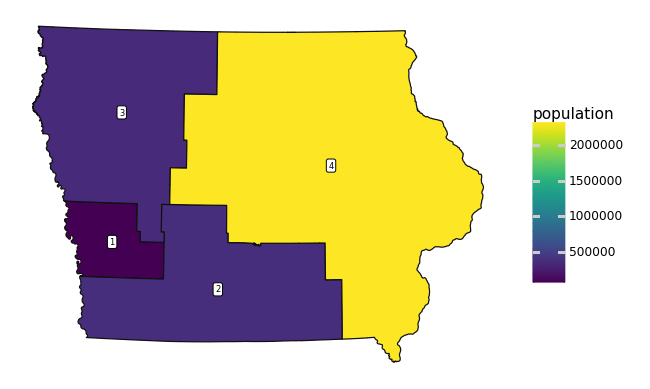

<ggplot: (8744339651082)>

In [30]:
# map_merged_districts(shapef_ia_pt1mapping,'combined_label')
map_merged_districts(shapef_ia_pt1mapping,'district_label')

In [31]:
shapef_ia_pt1output[['population','temp_district','district_label']]

,population,temp_district,district_label
0,133122,42,1
1,412348,61,2
2,385133,74,3
3,2259766,94,4


# New version of step 3

## Helper functions for step 3

In [51]:
# helper function: input is a single string
# output is a list of 2-element substrings (can adjust lenth of substring if desired)

# maybe should put something in to output an error if string length not divisible by segment length?

def stringsplit(stringinput,seglength=2):
    strlength=len(stringinput)
    nsets = int(strlength / seglength)
    county_list = []
    for i in range(nsets):
        county_list.append(stringinput[0+seglength*i:seglength+seglength*i])
    
    return county_list


In [52]:
# helper function: input is a shapefile with n (=4) rows
#   containing a column "county_id_string" of concatenated county IDs
# output is 2 lists:
#       county_lists is a 4 element list. Each element is 
#           itself a list of county IDs from that district
#       county_count is a 4 element list. Each element is
#           the count of counties in the district
#           (could be dropped or calculated after the fact)
# also calls stringsplit, defined above

def county_listing(shapef):

    # a list of the concatenated county ids from each district
    districts_countystrings = list(shapef["county_id_string"])

    #should switch to the big n_districts? but maybe not, so this can work on partial-districtings?
    ndistr = len(shapef)

    county_lists = []

    # array of 4 zeros
    county_count = np.zeros(ndistr)

    for i in range(ndistr):
        #list of counties in district i
        stringlist = stringsplit(districts_countystrings[i])

        #number of counties in district i
        county_count[i] = len(stringlist)

        county_lists.append(stringlist)

    # county_count
    # county_lists
    return county_lists, county_count

In [53]:
# helper function: input is a shapefile with 'population' 
# column. output is a full matrix with SIGNED
# population differences between attributes
# row - col
# positive value in row i column j means that pop(i) > pop(j)
# negative value in row i column j means that pop(i) < pop(j)

def pop_diff_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    pop_diff_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(curr_n_districts):   
            pop_diff_mat[i,j] = temp_shapefile['population'].iloc[i] - temp_shapefile['population'].iloc[j]
    
    return pop_diff_mat


In [54]:
##### NEW version: pass in district indices and main dataframe for districts

## helper function: given a dataframe of movable counties
# and another dataframe of the district they're going to
# make a list of relative distances

def calculate_rel_dist(border_counties,district_gdf,old_index,new_index):
    n_border_counties = len(border_counties)
    distance_list = np.zeros((n_border_counties,3))

    for i in range(n_border_counties):
        oldx_dist = border_counties['xcentr_lon'].iloc[i] - district_gdf['xcentr_lon'].iloc[old_index]
        oldy_dist = border_counties['ycentr_lat'].iloc[i] - district_gdf['ycentr_lat'].iloc[old_index]

        # old_dist
        distance_list[i,0] = math.sqrt(oldx_dist**2 + oldy_dist**2)

        newx_dist = border_counties['xcentr_lon'].iloc[i] - district_gdf['xcentr_lon'].iloc[new_index]
        newy_dist = border_counties['ycentr_lat'].iloc[i] - district_gdf['ycentr_lat'].iloc[new_index]

        # new_dist
        distance_list[i,1] = math.sqrt(newx_dist**2 + newy_dist**2)

        ## relative_distance: old - new
        # we'll move the county with highest relative distance
        distance_list[i,2] = distance_list[i,0] - distance_list[i,1]

    #we only need relative distances, not the component parts
    #so we could just make an n x 1 list instead of n x 3
    rel_dist = distance_list[:,2]
    return rel_dist

In [36]:
# helper function
# input is a shapefile with attributes of single counties (and columns as labeled below)
#       usually:  shapef_ia_step3
# output is a shapefile with attributes of districts
#       usually: shapef_step3_dissolved

def dissolve_by_district(county_shapefile):
    dissolved_shapefile = county_shapefile.dissolve(
        by="district_number",
        aggfunc = {
            "population": "sum",
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            "county_id_string": "sum", #sum = concatenation here b/c string
            "district_number": "first"
        }
   
    )

    dissolved_shapefile['xcentr_lon'] = dissolved_shapefile.centroid.x
    dissolved_shapefile['ycentr_lat'] = dissolved_shapefile.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    dissolved_shapefile = dissolved_shapefile.reset_index(drop=True)

    return dissolved_shapefile

In [55]:
## function to map counties categorically by district number
# taken from the one at the end of the notebook (from way long ago/adapted from oregon map)
# there's some issue with the categorical district numbers for now, so it's treating them 
# like continuous variables instead. not great, but not too terrible

color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

#data_label: 'county_id', 'population', 'NAME10', 'county_id_string', etc
def distmap_by_county(map_data,data_label):
    plot_distmap = (
        ggplot(map_data)
    + geom_map(aes(fill='district_number')
        ,show_legend=False
        ) 
    # + geom_map(aes(fill=str('district_number')))      #swap commenting on this line and the above to make district categorical!
    + geom_label(aes(x='xcentr_lon', y='ycentr_lat', label=data_label,size=2)
        , show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            # figure_size=(7, 4)      #this stretches shit?
            )
    # + scale_fill_manual(values=color_dict)        #uncomment this line to make district categorical!
    )
   
    return plot_distmap



## Step 3 main section:

* identifying county to move (from where/to where)
* then remove its index from its old district and append to the new one
* then remake whole-district shapefiles
* then repeat

In [133]:
##-------------------    Initialization: processing districted output ------------------------------------------
shapef_ia_bydist_initial = shapef_ia_pt1output.copy()

# drop: 'NAME10' (was just "2" for most-recently-merged attribute)
#       'COUNTYFP10' (concatenated FIPS code)
#       'county_id'  (summed county ids) 
#       'temp_district'  (1 arbitrary "root" county code) 
shapef_ia_bydist_initial = shapef_ia_bydist_initial.drop(columns=['NAME10', 'COUNTYFP10','county_id','temp_district'])


#-----------------------   Setting up lists of county IDs for each district  ------------------------------------
county_listing_temp = county_listing(shapef_ia_bydist_initial)
countyid_lists = county_listing_temp[0].copy()
county_count = county_listing_temp[1].copy()





##----------------   new copy of main shapefile just for this step (to not mess up elsewhere) -------------
#       #will be adding a column for the district something is in
shapef_ia_step3 = shapef_ia_fordistricting.copy()

#first dump the temp_district column
shapef_ia_step3 = shapef_ia_step3.drop(columns=['temp_district'])

#could just do the loop directly in shapef_ia_step3, 
#instead of creating distr_dict and then merging?
#but the standalone distr_dict might be helpful, too

distr_dict = pd.DataFrame()

distr_dict['county_id']= range(n_counties)
distr_dict['county_id_string']= distr_dict['county_id'].astype(str).str.pad(2,fillchar='0')
distr_dict['district_number'] = np.zeros(99).astype(int)


for i in range(n_districts):    # iterate over all districts
    for j in range(len(countyid_lists[i])):  #iterate over all counties within each district
        distr_dict.loc[distr_dict['county_id_string']== countyid_lists[i][j],'district_number'] = i+1

# distr_dict

shapef_ia_step3 = shapef_ia_step3.merge(distr_dict[['county_id_string','district_number']],on='county_id_string').copy()
# shapef_ia_step3.head()
# shapef_ia_step3.info()

#----------------------------------------------------------------
#### make a new shapefile with single attributes for each district
#### diff than the output from step 2 because columns will be better for iterability
# automatically updates population, centroid, etc
shapef_step3_dissolved = dissolve_by_district(shapef_ia_step3)


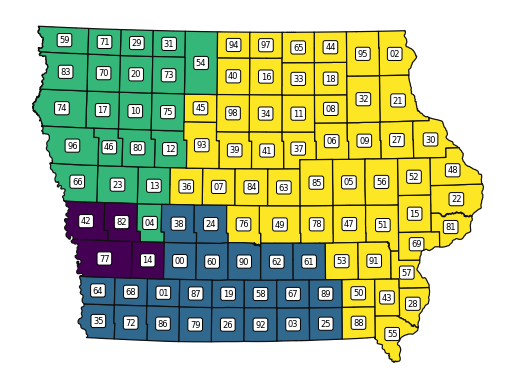

<ggplot: (8744333071894)>

In [134]:
# test that the labeling attached the right numbers to the right counties
#   this matches the (dissolved) figures from the end of step 2, so A-OK
distmap_by_county(shapef_ia_step3,'county_id_string')


# distmap_by_county(shapef_step3_dissolved,'district_number')

In [135]:
# iterations!

# APRIL 4: issue with 8th iteration should be fixed....
#       break on 8th iteration was b/c county 7 was called up, and there was a bug with
#       zeropadding on the .remove  (was doing str(7), vs '07'


for i in range(50):

    #no need to sort?
    district1_countylist = countyid_lists[0].copy()       #.sort()   ......
    district2_countylist = countyid_lists[1].copy()
    district3_countylist = countyid_lists[2].copy()
    district4_countylist = countyid_lists[3].copy()

    # pdb.set_trace()

    #new geodataframes for each district with counties as attributes
    #  (from main, un-districted shapefile, according to county_id_string content
    #   or since we now have a column with districts, no need to do the .isin here?
    #   could instead just do =shapef_ia_step3.loc[shapef_ia_step3['district_number'] == 1]
    dist1_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district1_countylist)]
    dist2_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district2_countylist)]
    dist3_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district3_countylist)]
    dist4_counties_GDF = shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(district4_countylist)]
    list_of_countyGDFs = [dist1_counties_GDF,dist2_counties_GDF,dist3_counties_GDF,dist4_counties_GDF]


    #-----------find neighboring districts with the greatest population difference---------------------
    #adjacencey matrix for 4 districts
    adj_mat_array = adj_mat_calc(shapef_step3_dissolved).to_numpy()         #iterable

    #SIGNED population difference array. # row minus col
    # positive value in row i column j means that pop(i) > pop(j)
    # negative value in row i column j means that pop(i) < pop(j)
    pop_diff_array = pop_diff_matrix(shapef_step3_dissolved)            #iterable

    # zero out any pairs that aren't adjacent  (for numpy arrays, "*" is elementwise multiplication)
    neighbor_popdiff = adj_mat_array * pop_diff_array

    #maxpopdiff_loc is an ordered pair giving the location of the
    #maximum value within neighbor_popdiff. Note!! Indexed on (0,n-1)!
    maxpopdiff_loc = np.unravel_index(np.argmax(neighbor_popdiff, axis=None), neighbor_popdiff.shape)

    #big district is the *row*, so first element of ordered pair
    big_dist_index = maxpopdiff_loc[0]
    #small district is the *column*, so second element of ordered pair
    small_dist_index = maxpopdiff_loc[1]

    print("Iteration %d. The big neighbor district is district %d. The small neighbor district is district %d." \
        % (i+1,             \
           big_dist_index + 1,   \
           small_dist_index + 1\
           ) )
    
    print("The big neighbor district has %d counties. The small neighbor district has %d counties." \
        % (len(countyid_lists[big_dist_index]), len(countyid_lists[small_dist_index]))
        )


    #----------find which county will be swapped from "bigdist" to "smalldist"----------------------
    #from the list of 4 dataframes (each of diff districts, undissolved)
    #we call the dataframe of the big district
    #this should just match dist4_counties_GDF
    bigdist_countyGDF = list_of_countyGDFs[big_dist_index].copy()

    #dataframe of counties in the Big district which are 
    #adjacent to the Small district so which we might move
    #   WATCH OUT for cases where moving a county messes up contiguity??
    #   remember that adjacency includes kitty-corner neighbors....
    #   the relative-distance ranking should make that difficult, though?
    smalldist = shapef_step3_dissolved.iloc[[small_dist_index]].copy()      #could instead put this in the next line, but it's super long already
    bigdist_movable = bigdist_countyGDF.loc[bigdist_countyGDF.intersects(smalldist.unary_union)].reset_index(drop=True).copy()
    #reset index so it is (0,n-1), instead of sparse indexing based on where the county was within the district
    #   we retain the original county id in 'county_id'


    #helper function from above: creates a list with relative distance metric
    # for each movable county. we will move the county with max value here
    #np.argmax just gives us index of the highest value
    #           could separately find the actual highest value, but doesn't seem necessary?
    # calculate_rel_dist(bigdist_movable,district_gdf,old/big index, new/small index)
    movingcounty_index = np.argmax(calculate_rel_dist(bigdist_movable,shapef_step3_dissolved,big_dist_index,small_dist_index))

    #return county id of county we're taking out
    #first runthtough (with seed = 2 from above): county to move is Humboldt, id = 45
    county_to_move = bigdist_movable.iloc[[movingcounty_index]]
    county_id_to_move = bigdist_movable.loc[movingcounty_index,'county_id']             # an int
    county_id_str_to_move = bigdist_movable.loc[movingcounty_index,'county_id_string']  # a zeropadded string

    print("The county id to move is %s." \
    % (county_id_str_to_move)           #could use int instead of str if we wanted
    )

    #-----------swap county between districts and update for re-run ---------------------------

    #remove the county id from the list of counties in the big district:
    countyid_lists[big_dist_index].remove(county_id_str_to_move)

    #add the county id to the list of counties in the small district:
    countyid_lists[small_dist_index].append(county_id_str_to_move)

    #update the district in the shapefile (+1 since districts are [1,4] not [0,3]):
    #           could use regular county_id or county_id_string
    shapef_ia_step3.loc[shapef_ia_step3['county_id_string']==county_id_str_to_move, 'district_number'] = small_dist_index +1

    #update the dissolved shapefile:
    shapef_step3_dissolved = dissolve_by_district(shapef_ia_step3)

    print("After shifting, the big neighbor district has %d counties. The small neighbor district has %d counties." \
    % (len(countyid_lists[big_dist_index]), len(countyid_lists[small_dist_index]))
    )


Iteration 1. The big neighbor district is district 4. The small neighbor district is district 3.
The big neighbor district has 51 counties. The small neighbor district has 21 counties.
The county id to move is 45.
After shifting, the big neighbor district has 50 counties. The small neighbor district has 22 counties.
Iteration 2. The big neighbor district is district 4. The small neighbor district is district 3.
The big neighbor district has 50 counties. The small neighbor district has 22 counties.
The county id to move is 36.
After shifting, the big neighbor district has 49 counties. The small neighbor district has 23 counties.
Iteration 3. The big neighbor district is district 4. The small neighbor district is district 3.
The big neighbor district has 49 counties. The small neighbor district has 23 counties.
The county id to move is 93.
After shifting, the big neighbor district has 48 counties. The small neighbor district has 24 counties.
Iteration 4. The big neighbor district is dist

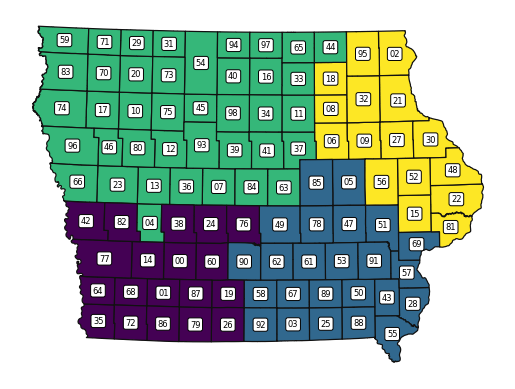

<ggplot: (8744334086340)>

In [136]:
distmap_by_county(shapef_ia_step3,'county_id_string')

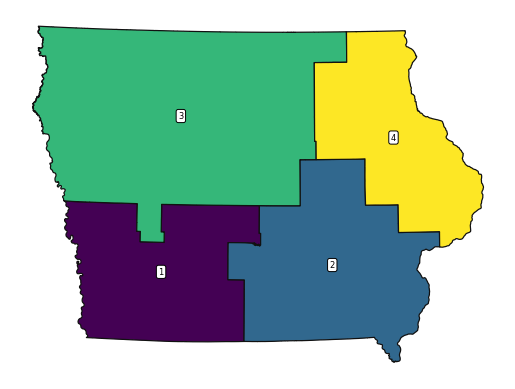

<ggplot: (8744341757886)>

In [137]:
distmap_by_county(shapef_step3_dissolved,'district_number')

In [138]:
shapef_step3_dissolved[['district_number','population']]

,district_number,population
0,1,850292
1,2,658763
2,3,795104
3,4,886210


### notes-to-self manually checking population adjustments from first 3 iterations

In [44]:
shapef_ia_step3.loc[shapef_ia_step3['county_id_string'].isin(['45','36','93'])]

,COUNTYFP10,NAME10,geometry,population,county_id,xcentr_lon,ycentr_lat,county_id_string,district_number
36,073,Greene,"POLYGON ((364955.036 4645564.668, 364958.141 4...",8771,36,384380.986817,4.654735e+06,36,3
45,091,Humboldt,"POLYGON ((401417.632 4751324.379, 402363.225 4...",9597,45,401247.022382,4.736698e+06,45,3
93,187,Webster,"POLYGON ((410635.291 4721945.854, 410978.859 4...",36999,93,402790.030677,4.697953e+06,93,3


In [45]:
#initial district population numbers here!
shapef_ia_pt1output[['population','temp_district','district_label']]

,population,temp_district,district_label
0,133122,42,1
1,412348,61,2
2,385133,74,3
3,2259766,94,4


In [46]:
# initial part 1 allocation:
# district 3 =   385,133
# district 4 = 2,259,766

#switch humboldt (9597), then greene (8771), then Webster (36999)

In [47]:
2259766 - 9597 - 8771 - 36999

2204399

In [48]:
385133 + 9597 + 8771 + 36999

440500

## visualizations

In [49]:
#input: shapefile of counties within a particular district 
#   (after undergoing identity overlay)
#   label_field options: 'NAME10', 'population_2', 'county_id', 'county_id_string_2', etc

def map_unmerged_districts(new_shapefile,label_field):
    map_counties_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=label_field,size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_counties_by_district

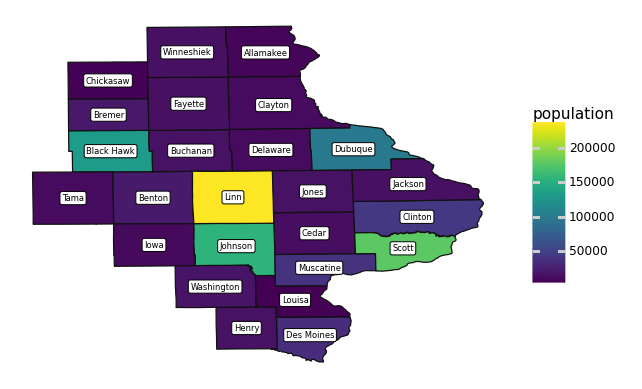

<ggplot: (8744334041013)>

In [50]:
map_unmerged_districts(dist4_counties_GDF,'NAME10')

# future steps

(3a) Among all pairs of districts that border one another, identify the pair with the greatest disparity in district population. Within this pair,
let us denote the more populated district as $i$ and the less populated district as $j$.

(3b) Identify the set of all precincts currently within district $i$ that could be reassigned to district $j$ without violating the geographic contiguity of either district $i$ or $j$.

In [202]:
# we can definitely figure out a list of counties 
# in district i which border district j

# but!
# (rare case since the districts are built compactly):
# what if removing that county from district i
# makes district i no longer contiguous?

# maybe just build in a check that district i is
# still contiguous after the swap?

In [ ]:
# to do:
# rename "shapef_ia_running"?
# rename/reindex districts?

# get a list of counties which ended up in each district
#   geopandas overlay, OR de-concatenate string of county_ids (or of FIPS)
# make little adjacency matrices of district j vs (counties in district i)?

#could use laplacian to check that district i doesn't become disconnected?

(3c) For each precinct $p$ satisfying the criterion in step 3b, define $D_p$ as precinct $p$’s geographic distance to the centroid of district $i$, minus
precinct $p$’s distance to the centroid of district $j$.

(3d) Among the set of precincts satisfying the criteria in step 3b, select the precinct, $p$, with the highest value of Dp . Reassign this precinct from
district $i$ to district $j$.

## District size bounds

In [10]:
ideal_district_size=state_population/n_districts
tolerance=.01
district_maximum=int(ideal_district_size*(1+tolerance))
district_minimum=int(ideal_district_size*(1-tolerance))

# Leftover maps and visualization tools from Iowa_redistricting (ignore until above stuff is working)

## Visualizing the districts

### Prepping the data for visualization

In [16]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'county_id': i,
            'district': j+1,
            'assignment': int(assignment[i][j].value()*(j+1)),
            'allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['assignment'] != 0]
results = results.sort_values(['county_id', 'district'])
results


,county_id,district,assignment,allocation
2,0,3,3,7496
7,1,4,4,3704
9,2,2,2,14061
14,3,3,3,12317
16,4,1,1,5674
...,...,...,...,...
379,94,4,4,10679
381,95,2,2,20070
384,96,1,1,105941
391,97,4,4,7443


In [17]:
results = results.merge(census_df, on='county_id')
results

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude
0,0,3,3,7496,Adair,7496,001,41.328528,-94.478164
1,1,4,4,3704,Adams,3704,003,41.021656,-94.696906
2,2,2,2,14061,Allamakee,14061,005,43.274964,-91.382751
3,3,3,3,12317,Appanoose,12317,007,40.744683,-92.870345
4,4,1,1,5674,Audubon,5674,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...,...
96,94,4,4,10679,Winnebago,10679,189,43.378124,-93.743488
97,95,2,2,20070,Winneshiek,20070,191,43.292989,-91.850788
98,96,1,1,105941,Woodbury,105941,193,42.393220,-96.053296
99,97,4,4,7443,Worth,7443,195,43.373491,-93.248533


In [18]:
results.loc[(results['allocation'])!=(results['population'])]

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude
51,51,2,2,30571,Johnson,152854,103,41.668737,-91.588812
52,51,3,3,122283,Johnson,152854,103,41.668737,-91.588812
77,76,1,1,393920,Polk,492401,153,41.684281,-93.569720
78,76,3,3,98481,Polk,492401,153,41.684281,-93.569720


In [ ]:
# results_test=results.copy()

In [ ]:
# results_test['multiple_county_name'] = results_test['county'].shift(periods=1)
# results_test['multiple_district'] = results_test['district'].shift(periods=1).fillna(99).astype(int)


In [ ]:
# results_test

In [ ]:
# Edit the assignment for the case when a county has multiple assignments 
# for i in range(0,len(results_test)):
#     if results_test['county'].loc[i] == results_test['multiple_county_name'].loc[i]:
#         results_test.loc[i, 'assignment'] =   int(str(results_test['district'].loc[i]) + \
#                                                         str(results_test['multiple_district'].loc[i]))
# results_test = results_test.sort_values(['district','county'])
# results_test.index = results_test['county_id']

In [ ]:
# results_test.loc[results_test['county_id']==76]

## Creating the maps

In [19]:
color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

def iowa_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with county IDs labels
    (2) A map with county labels
    """
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county_id',size=2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    # plot_map_county_ids = (
    #     ggplot(map_data)
    # + geom_map(aes(fill=str('Assignment'))) 
    # + geom_label(aes(x='longitude', y='latitude', label='population', size=5), 
    #              show_legend=False)
    # + theme_minimal()
    # + theme(axis_text_x=element_blank(),
    #         axis_text_y=element_blank(),
    #         axis_title_x=element_blank(),
    #         axis_title_y=element_blank(),
    #         axis_ticks=element_blank(),
    #         panel_grid_major=element_blank(),
    #         panel_grid_minor=element_blank(),
    #         figure_size=(7, 4))
    # + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels
# , plot_map_county_ids


In [24]:
shapefile_and_assignments = shapefile_iowa.merge(results, on='COUNTYFP10')
# map_first_pass['District'] = map_first_pass['District']+1
shapefile_and_assignments.head()


,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,CD,geometry,county_id,district,assignment,allocation,county,population,latitude,longitude
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157...",0,3,3,7496,Adair,7496,41.328528,-94.478164
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158...",1,4,4,3704,Adams,3704,41.021656,-94.696906
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500...",2,2,2,14061,Allamakee,14061,43.274964,-91.382751
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812...",3,3,3,12317,Appanoose,12317,40.744683,-92.870345
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688...",4,1,1,5674,Audubon,5674,41.679178,-94.904312


In [25]:
# map_first_pass['District'] = map_first_pass['District'].astype('category')
shapefile_and_assignments['assignment'] = shapefile_and_assignments['assignment'].astype("category")

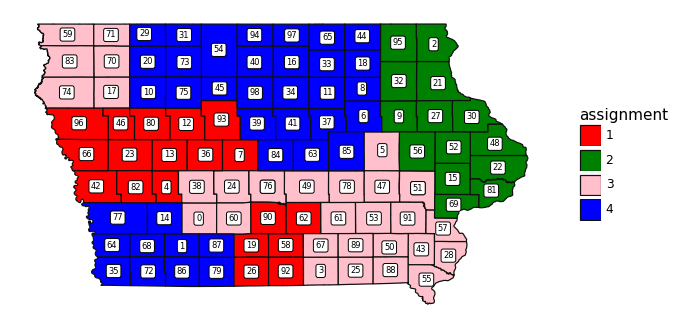

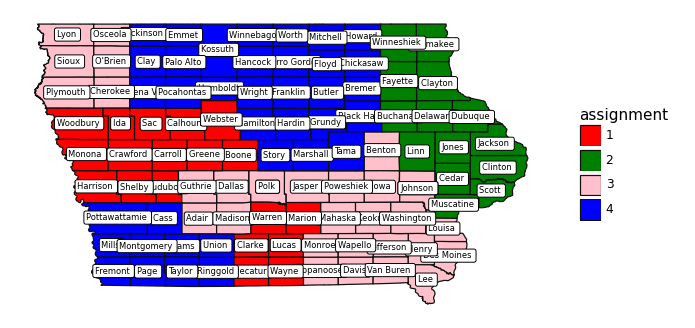

(<ggplot: (399377418)>, <ggplot: (399394624)>)

In [26]:
iowa_map(shapefile_and_assignments)

In [23]:
district_totals = pd.DataFrame(results.groupby('district')['allocation'].sum().astype('int64'))
district_totals

,allocation
district,
1,795471
2,791872
3,805236
4,797790


# TEMP AT END: BETTER PICS FOR STEP 3

In [60]:
# import pandas as pd
# import geopandas as gp
from plotnine import *

%matplotlib inline



In [70]:
shapef_ia_step3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   district_number   99 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 7.7+ KB


In [72]:
shapef_ia_step3_FORMAP = shapef_ia_step3.copy()
shapef_ia_step3_FORMAP['district_number'] = shapef_ia_step3_FORMAP['district_number'].astype(str)

In [73]:
shapef_ia_step3_FORMAP.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   district_number   99 non-null     object  
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 7.7+ KB


In [81]:
shapef_ia_step3_FORMAP.loc[shapef_ia_step3_FORMAP['county_id'].isin([1,2,3])]

,COUNTYFP10,NAME10,geometry,population,county_id,xcentr_lon,ycentr_lat,county_id_string,district_number
1,003,Adams,"POLYGON ((347722.464 4557927.937, 347913.212 4...",3704,1,357154.753953,4.543364e+06,01,2
2,005,Allamakee,"POLYGON ((621990.182 4817526.586, 622024.806 4...",14061,2,631594.469070,4.793646e+06,02,4
3,007,Appanoose,"POLYGON ((491767.058 4517888.762, 491767.214 4...",12317,3,511092.713138,4.510250e+06,03,2


palette options:

    Accent (8 levels)
    Dark2 (8)
    Paired (12)
    Pastel1 (9)
    Pastel2 (8)
    Set1 (9)
    Set2 (8)
    Set3 (12)


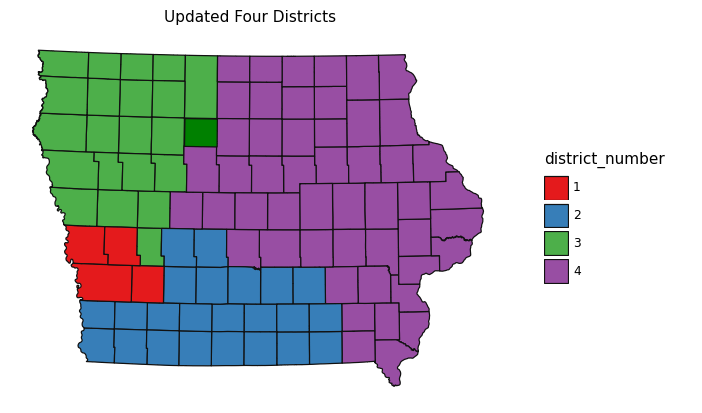

<ggplot: (8744333387587)>

In [132]:
def map_step3(main_shape):

    outputmap = (
        ggplot()
        + geom_map(main_shape,aes(fill='district_number'))
        #Version 1/Slide 1:
        # + labs(title="Initial Four Districts")
        #Version 2/Slide 2:
        # + geom_map(main_shape.loc[main_shape['county_id'].isin([36,40,45,93,94,98])],color='yellow',fill=None,size=1.25)
        # + labs(title="District 4 Counties Bordering District 3")
        #Version 3/Slide 3:
        # + geom_map(main_shape.loc[main_shape['county_id'].isin([45])],color=None,fill='yellow',alpha=0.5)
        # + labs(title="District 4 County with highest $D_c$ Value")
        #Version 3/Slide 3:
        + geom_map(main_shape.loc[main_shape['county_id'].isin([45])],fill='green')
        + labs(title="Updated Four Districts")
        # all (again)
        + scale_fill_brewer(type='qual',palette="Set1")
        + coord_cartesian()
        + theme_void()
    )
    return outputmap

map_step3(shapef_ia_step3_FORMAP)

In [ ]:
## function to map counties categorically by district number
# taken from the one at the end of the notebook (from way long ago/adapted from oregon map)
# there's some issue with the categorical district numbers for now, so it's treating them 
# like continuous variables instead. not great, but not too terrible

color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

#data_label: 'county_id', 'population', 'NAME10', 'county_id_string', etc
def step3_maps(map_data,data_label):
    plot_distmap = (
        ggplot(map_data)
    + geom_map(aes(fill='district_number')
        ,show_legend=False
        ) 
    # + geom_map(aes(fill=str('district_number')))      #swap commenting on this line and the above to make district categorical!
    + geom_label(aes(x='xcentr_lon', y='ycentr_lat', label=data_label,size=2)
        , show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            # figure_size=(7, 4)      #this stretches shit?
            )
    # + scale_fill_manual(values=color_dict)        #uncomment this line to make district categorical!
    )
   
    return plot_distmap

